In [243]:
from functools import partial
import sys, os, math, time, json
import numpy as np
import tqdm
from matplotlib import pyplot as plt
from matplotlib import cm
import pandas as pd
%matplotlib notebook

import haiku as hk
import tree as dm_tree

import jax.numpy as jnp
import jax
import jax_bayes
jax.config.update('jax_platform_name', 'cpu') # for eval notebook

In [244]:
sys.path.append('../2d_exp')
from make_logprobs import (
    make_circular_mog, 
    make_ring_mixture,
    make_grid_mog,
    compute_mmd2
)

## Plotting functions & Utilities

In [245]:
def plot_target(ax, tgt_logprob):
    if tgt_logprob == 'moons':
        raise ValueError()
        logprob = make_two_moons().logprob
    elif tgt_logprob == 'circular_mog':
        logprob = make_circular_mog().logprob
        pts = np.linspace(-3, 3, 1000)
    elif tgt_logprob == 'two_rings':
        logprob = make_ring_mixture().logprob
        pts = np.linspace(-3, 3, 1000)
    elif tgt_logprob == 'grid_mog':
        logprob = make_grid_mog().logprob
        pts = np.linspace(-6, 6, 1000)
    else:
        raise ValueError(f"Got invalid tgt_logprob {tgt_logprob}!")
    X, Y = np.meshgrid(pts, pts)
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y

    Z = np.exp(jax.vmap(jax.vmap(logprob))(pos))
    Z = Z/Z.max()
    Z = jnp.expand_dims(Z, axis=-1)
    
    ax.imshow(Z, extent=(X.min(), X.max(), Y.max(), Y.min()),
       interpolation='nearest', cmap=cm.viridis)

    ax.set_xticks([])
    ax.set_yticks([])

In [246]:
def plot_samples_hist(ax, samples):
    H, xpts, ypts, _ = ax.hist2d(samples[:,0], samples[:, 1], bins=100, range=((-6, 6), (-6, 6)))
#     H, xpts, ypts, _ = ax.hist2d(samples[:,0], samples[:, 1], bins=100, range=((-3, 3), (-3, 3)))

def plot_mcmc_hist(ax, dist, alg, data_dir=None):
    if data_dir is None:
        data_dir = f'./final_data/{dist}/seed1/{alg}'
    else:
        data_dir = data_dir.format(dist=dist, alg=alg, seed=1)
    samples = jnp.load(os.path.join(data_dir, 'tgt_samples.npy'))
    print(samples.shape)
    
    plot_samples_hist(ax, samples)

In [247]:
def plot_gt_hist(ax, tgt_logprob):
    if tgt_logprob == 'moons':
        raise ValueError()
        dist = make_two_moons()
    elif tgt_logprob == 'circular_mog':
        dist = make_circular_mog()
    elif tgt_logprob == 'two_rings':
        dist = make_ring_mixture()
    elif tgt_logprob == 'grid_mog':
        dist = make_grid_mog()
    else:
        raise ValueError(f"Got invalid tgt_logprob {tgt_logprob}!")
    
    samples = dist.sample(jax.random.PRNGKey(0), n_samples=2_000)
    
    plot_samples_hist(ax, samples)

# f, axes = plt.subplots()
# plot_gt_hist(ax, 'circular_mog')

In [196]:
!ls ../2d_exp/final_data_correction/

circular_mog  grid_mog	two_rings


In [278]:
# dist = 'circular_mog'
# alg = 'bg'

def get_mmd_df(dist, alg, data_dir=None):
    ts, mmds = [], []
    for seed in range(1, 6):
        seed_mmds = []
        if data_dir is None:
            res_dir = f'../2d_exp/final_data/{dist}/seed{seed}/{alg}'
        else:
            res_dir = data_dir.format(dist=dist, seed=seed, alg=alg)
        with open(os.path.join(res_dir, 'all_mmds.csv'), 'r') as f:
            for row in f:
                i, mmd = row.split(',')[:2]
                if seed == 1: 
                    ts.append(int(i))
                seed_mmds.append(float(mmd))

            mmds.append(seed_mmds)
            
    assert len(set(len(x) for x in mmds)) == 1
    mmds_df = pd.DataFrame(list(zip(*mmds)), index=ts, columns=[f'seed{i}' for i in range(1, 6)])
    return mmds_df

def get_walltime_df(dist, alg, data_dir=None):
    ts, data = [], []
    for seed in range(1, 6):
        seed_data = []
        if data_dir is None:
            data_dir = '../2d_exp/final_data/{dist}/seed{seed}/{alg}'
        curr_data_dir = data_dir.format(dist=dist, seed=seed, alg=alg)
        with open(os.path.join(curr_data_dir, 'all_mmds.csv'), 'r') as f:
            for i, row in enumerate(f):
                i, _, d = row.split(',')
                if seed == 1: 
                    ts.append(int(i))
                seed_data.append(float(d))

            data.append(seed_data)
            
    assert len(set(len(x) for x in data)) == 1
    data_df = pd.DataFrame(list(zip(*data)), index=ts, columns=[f'seed{i}' for i in range(1, 6)])
    data_df = data_df.diff().dropna()
    return data_df

print(get_walltime_df('two_rings', 'linear'))

         seed1     seed2     seed3     seed4     seed5
10    0.183598  0.121140  0.129641  0.121985  0.115959
20    0.001617  0.000997  0.001008  0.001652  0.000965
30    0.001608  0.000958  0.000972  0.001603  0.000950
40    0.001428  0.001001  0.001047  0.001649  0.000938
50    0.000978  0.000959  0.000981  0.001047  0.000923
...        ...       ...       ...       ...       ...
9950  0.001011  0.000951  0.000966  0.000942  0.000948
9960  0.000993  0.000953  0.000968  0.000953  0.000964
9970  0.001001  0.000951  0.000961  0.000951  0.000947
9980  0.000979  0.000959  0.001081  0.000954  0.000952
9990  0.000976  0.000961  0.000975  0.000946  0.000946

[999 rows x 5 columns]


In [249]:
def plot_mmd_curve(ax, dist, alg, label=None, data_dir=None, **plot_kwargs):
    mmd_df = get_mmd_df(dist, alg, data_dir=data_dir)
    mean = mmd_df.mean(axis=1)
    std = mmd_df.std(axis=1)
    lower, upper = mean - std, mean + std
    
    if 'color' in plot_kwargs:
        ax.fill_between(mean.index, lower, upper, alpha=0.3, 
                        lw=0, color=plot_kwargs['color'])
    else:
        ax.fill_between(mean.index, lower, upper, alpha=0.3)
    ax.plot(mean, label=label, **plot_kwargs)

def plot_mmd_curve_ngrads(ax, dist, alg, label=None, data_dir=None):
    mmd_df = get_mmd_df(dist, alg, data_dir=data_dir)
    mean = mmd_df.mean(axis=1)
    std = mmd_df.std(axis=1)
    lower, upper = mean - std, mean + std
    
    if label in ['Linear']:
        xs = mean.index * 2
    elif label in ['Accept-Reject', 'Boltzmann-Gibbs']:
        xs = mean.index * 4
    
    ax.fill_between(xs, lower, upper, alpha=0.3)
    ax.plot(xs, mean, label=label)

def plot_mmd_curve_walltime(ax, dist, alg, label=None, offset=2):
    mmd_df = get_mmd_df(dist, alg)
    wall_df = get_walltime_df(dist, alg)
    mmd_df, wall_df = mmd_df.iloc[offset:], wall_df.iloc[offset:]
    
    mean = mmd_df.mean(axis=1)
    std = mmd_df.std(axis=1)
    lower, upper = mean - std, mean + std
    
    xs = wall_df.mean(axis=1).cumsum()
    xs.values[0] = 0
    
    ax.fill_between(xs, lower, upper, alpha=0.3)
    ax.plot(xs, mean, label=label)

## Make the Figures

### Plot Sample Histograms

<IPython.core.display.Javascript object>


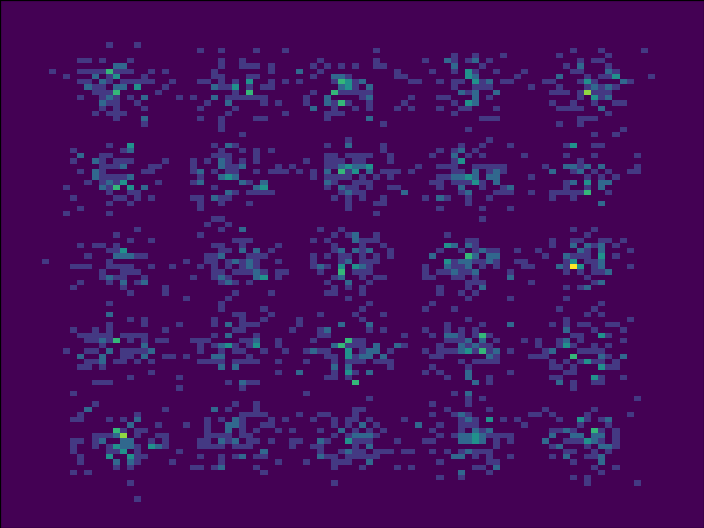

In [133]:
f, ax = plt.subplots()


data_dir = '../2d_exp/final_data/{dist}/seed{seed}/{alg}'
# dist = 'circular_mog'
# dist = 'two_rings'
dist = 'grid_mog'

# plot_mcmc_hist(ax, dist, 'linear', data_dir=data_dir)
# plot_mcmc_hist(ax, dist, 'ar', data_dir=data_dir)
# plot_mcmc_hist(ax, dist, 'bg', data_dir=data_dir)
plot_gt_hist(ax, dist)
# plt.legend()
if dist == 'circular_mog' or dist == 'two_rings':
    ax.set_xlim((-3, 3))
    ax.set_ylim((-3, 3))

ax.set_xticks([])
ax.set_yticks([])

plt.subplots_adjust(
    left=0.0,
    bottom=0.0,
    right=1.0,
    top=1.0,
    wspace=0.0,
    hspace=0.0)

### Plot Target Density

<IPython.core.display.Javascript object>


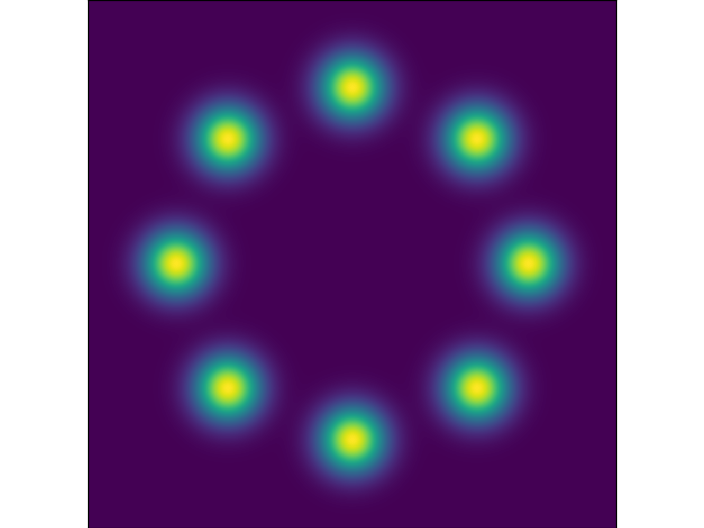

In [113]:
f, ax = plt.subplots()


data_dir = '../2d_exp/final_data/{dist}/seed{seed}/{alg}'
dist = 'circular_mog'
# dist = 'two_rings'
# dist = 'grid_mog'

plot_target(ax, dist)

dist2ylabel = {
    'circular_mog': '"Circular MoG" Distribution',
    'two_rings': '"Two Rings" Distribution',
    'grid_mog': '"Grid MoG" Distribution'
}

# ax.set_ylabel(dist2ylabel[dist], fontsize=25)
# if dist == 'grid_mog':
#     ax.set_xlabel('Target Density', fontsize=25)

ax.set_xticks([])
ax.set_yticks([])

# f.tight_layout()
plt.subplots_adjust(
    left=0.0,
    bottom=0.0,
    right=1.0,
    top=1.0,
    wspace=0.0,
    hspace=0.0)

### Main MMD2 Plots

<IPython.core.display.Javascript object>


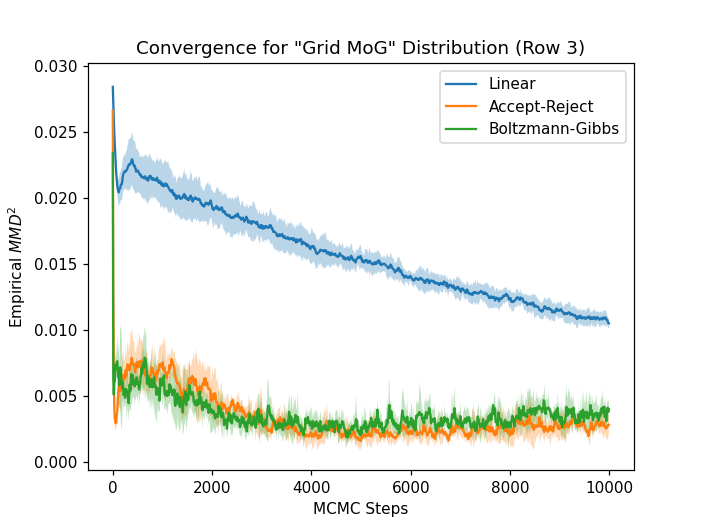

In [263]:
# make main plots
f, ax = plt.subplots()
# dist = 'circular_mog'
# dist = 'two_rings'
dist = 'grid_mog'
dist2title = {
    'circular_mog': '"Circular MoG" Distribution (Row 1)',
    'two_rings': '"Two Rings" Distribution (Row 2)',
    'grid_mog': '"Grid MoG" Distribution (Row 3)'
}
data_dir = '../2d_exp/final_data/{dist}/seed{seed}/{alg}'
plot_mmd_curve(ax, dist, 'linear', label='Linear', data_dir=data_dir)
plot_mmd_curve(ax, dist, 'ar', label='Accept-Reject', data_dir=data_dir)
plot_mmd_curve(ax, dist, 'bg', label='Boltzmann-Gibbs', data_dir=data_dir)
if dist == 'circular_mog':
    ax.set_ylim([0, 0.035])
ax.set_ylabel(r'Empirical $MMD^2$')
ax.set_xlabel('MCMC Steps')
ax.set_title(f"Convergence for {dist2title[dist]}")
ax.legend()

In [42]:
plt.rcParams['text.usetex'] = False

### Comparison with [1]

<IPython.core.display.Javascript object>


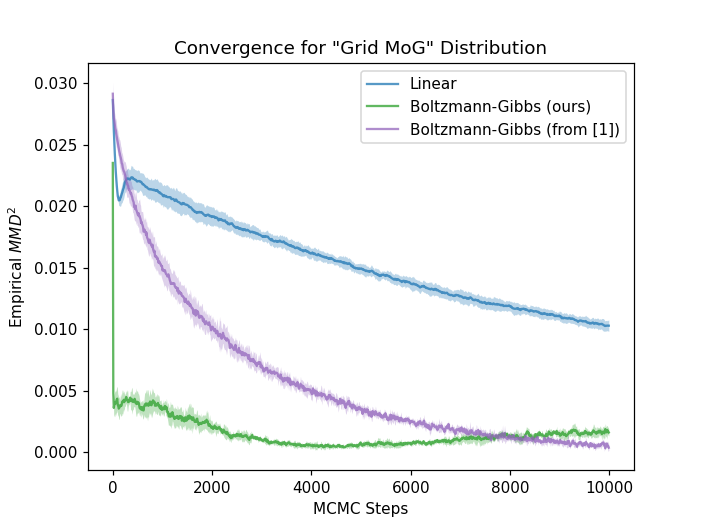

In [216]:
# make dM comparison plots
f, ax = plt.subplots()
# dist = 'circular_mog'
# dist = 'two_rings'
dist = 'grid_mog'

jv_data_dir = '../2d_exp/final_data/{dist}/seed{seed}/{alg}'
dm_data_dir = '../2d_exp_delmoral/final_data/{dist}/seed{seed}/{alg}'

dist2title = {
    'circular_mog': '"Circular MoG" Distribution',
    'two_rings': '"Two Rings" Distribution',
    'grid_mog': '"Grid MoG" Distribution'
}

# alpha= 1.0
alpha = 0.75
plot_mmd_curve(ax, dist, 'linear', label='Linear', data_dir=jv_data_dir, alpha=alpha, color='C0')
# plot_mmd_curve(ax, dist, 'ar', label='Accept-Reject (ours)', data_dir=jv_data_dir, alpha=alpha, color='C1')
plot_mmd_curve(ax, dist, 'bg', label='Boltzmann-Gibbs (ours)', data_dir=jv_data_dir, alpha=alpha, color='C2')
# plot_mmd_curve(ax, dist, 'ar', label='Accept-Reject (from [1])', data_dir=dm_data_dir, alpha=alpha, color='C3')
plot_mmd_curve(ax, dist, 'bg', label='Boltzmann-Gibbs (from [1])', data_dir=dm_data_dir, alpha=alpha, color='C4')

if dist == 'circular_mog':
    ax.set_ylim([0, 0.035])
ax.set_ylabel(r'Empirical $MMD^2$')
ax.set_xlabel('MCMC Steps')
ax.set_title(f"Convergence for {dist2title[dist]}")

ax.legend()

### All Curves on Same Figure

<IPython.core.display.Javascript object>


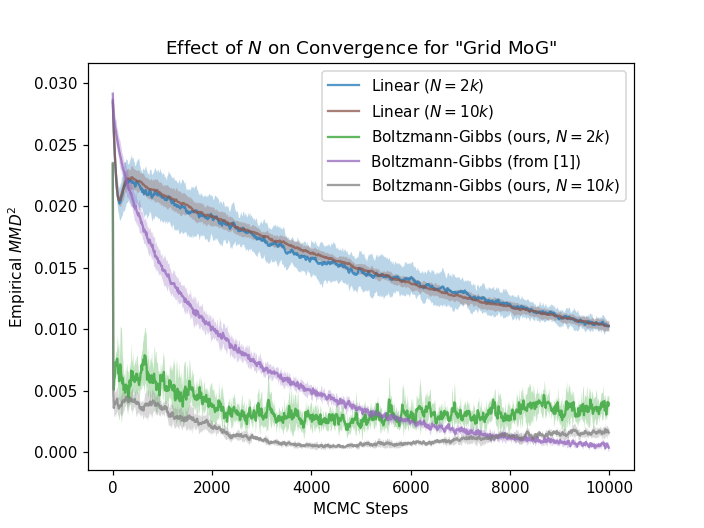

In [241]:
# make num samples comparison plots
f, ax = plt.subplots()
# dist = 'circular_mog'
# dist = 'two_rings'
dist = 'grid_mog'

N2k_data_dir = '../2d_exp/final_data/{dist}/seed{seed}/{alg}'
N10k_data_dir = '../2d_exp/final_data_addtl/{dist}/seed{seed}/{alg}'
dm_data_dir = '../2d_exp_delmoral/final_data/{dist}/seed{seed}/{alg}'

dist2title = {
    'circular_mog': '"Circular MoG"',
    'two_rings': '"Two Rings"',
    'grid_mog': '"Grid MoG"'
}

# alpha= 1.0
alpha = 0.75
plot_mmd_curve(ax, dist, 'linear', label='Linear ($N=2k$)', data_dir=N2k_data_dir, alpha=alpha, color='C0')
plot_mmd_curve(ax, dist, 'linear', label='Linear ($N=10k$)', data_dir=N10k_data_dir, alpha=alpha, color='C5')
# plot_mmd_curve(ax, dist, 'ar', label='Accept-Reject (ours, $N=2k$)', data_dir=N2k_data_dir, alpha=alpha, color='C1')
# plot_mmd_curve(ax, dist, 'ar', label='Accept-Reject (ours, $N=10k$)', data_dir=N10k_data_dir, alpha=alpha, color='C6')
# plot_mmd_curve(ax, dist, 'ar', label='Accept-Reject (from [1])', data_dir=dm_data_dir, alpha=alpha, color='C3')
plot_mmd_curve(ax, dist, 'bg', label='Boltzmann-Gibbs (ours, $N=2k$)', data_dir=N2k_data_dir, alpha=alpha, color='C2')
plot_mmd_curve(ax, dist, 'bg', label='Boltzmann-Gibbs (from [1])', data_dir=dm_data_dir, alpha=alpha, color='C4')
plot_mmd_curve(ax, dist, 'bg', label='Boltzmann-Gibbs (ours, $N=10k$)', data_dir=N10k_data_dir, alpha=alpha, color='C7')


if dist == 'circular_mog':
    ax.set_ylim([0, 0.035])
ax.set_ylabel(r'Empirical $MMD^2$')
ax.set_xlabel('MCMC Steps')
ax.set_title(f"Effect of $N$ on Convergence for {dist2title[dist]}")

ax.legend()

### MMD2 vs # of Gradient Executions

<IPython.core.display.Javascript object>


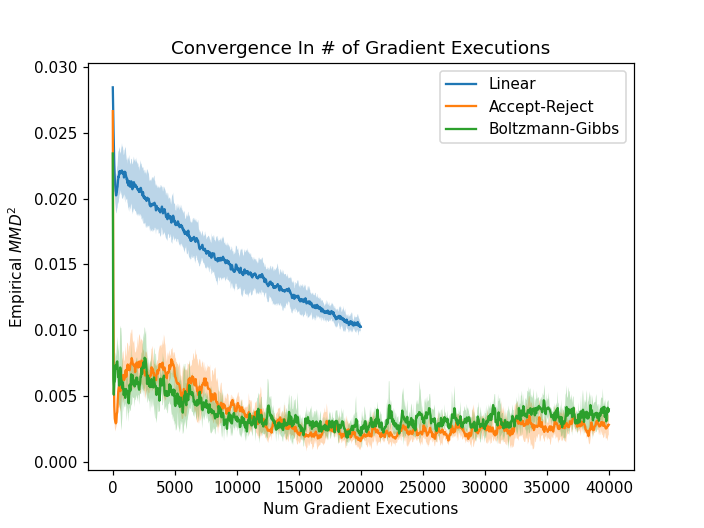

In [288]:
f, ax = plt.subplots()
# dist = 'circular_mog'
# dist = 'two_rings'
dist = 'grid_mog'
data_dir = '../2d_exp/final_data/{dist}/seed{seed}/{alg}'
plot_mmd_curve_ngrads(ax, dist, 'linear', label='Linear')
plot_mmd_curve_ngrads(ax, dist, 'ar', label='Accept-Reject')
plot_mmd_curve_ngrads(ax, dist, 'bg', label='Boltzmann-Gibbs')
if dist == 'circular_mog':
    ax.set_ylim([0, 0.035])
ax.set_ylabel('Empirical $MMD^2$')
ax.set_xlabel('Num Gradient Executions')
ax.set_title('Convergence In # of Gradient Executions')
ax.legend()